In [2]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

C:\Users\natha\AppData\Local\Temp\ipykernel_26996\1183180518.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
#generate embeddings for protein sequences
# Path to data folder
directory = '../GATSol/dataset/'

# Load CSVs
df = pd.read_csv(directory + 'eSol_test.csv') #Replace with train/test as needed

# Convert to list
sequences_train = [(row['gene'], row['sequence']) for _, row in df.iterrows()]

# Load the ESM-2 model and alphabet
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Disable dropout for deterministic results

# Prepare a list to store embeddings
embeddings_list = []

# Loop through each sequence with tqdm to show progress
for batch_labels, batch_strs, batch_tokens in tqdm([batch_converter([seq]) for seq in sequences_train], desc="Generating Embeddings"):
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33])
    embedding = results["representations"][33].mean(dim=1)  # Mean pooling
    embeddings_list.append(embedding.cpu().numpy())

# Add embeddings to the DataFrame and save
df['embedding'] = embeddings_list
df.to_pickle(directory + 'eSol_test.pkl')  # Save with embeddings, replace with train/test as needed

In [4]:
directory = '../GATSol/dataset/'

# Load the DataFrame with embeddings
embeddings = pd.read_pickle(directory + 'eSol_Test.pkl')
print(embeddings.shape)
embeddings.head()

(660, 4)


,gene,solubility,sequence,embedding
0,acpS,0.84,MAILGLGTDIVEIARIEAVIARSGDRLARRVLSDNEWAIWKTHHQP...,"[[-0.065321095, -0.004576486, 0.040135056, -0...."
1,acpT,0.14,MYRIVLGKVSTLSAAPLPPGLREQAPQGPRRERWLAGRALLSHTLS...,"[[0.013997538, -0.07084464, 0.045143533, -0.00..."
2,acrA,0.65,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,"[[0.025458042, -0.025825232, -0.070221215, 0.0..."
3,acrR,0.52,MARKTKQEAQETRQHILDVALRLFSQQGVSSTSLGEIAKAAGVTRG...,"[[0.04623393, -0.03282278, -0.005630321, 0.024..."
4,ada,0.32,MKKATCLTDDQRWQSVLARDPNADGEFVFAVRTTGIFCRPSCRARH...,"[[0.011851333, -0.06914258, 0.060871135, -0.05..."


In [10]:
dimensions = embeddings.loc[0, 'embedding']
num_vectors = len(dimensions[0])
print(num_vectors)

1280


Shape of embeddings: (660, 1280)
Number of components needed for 95% variance: 199


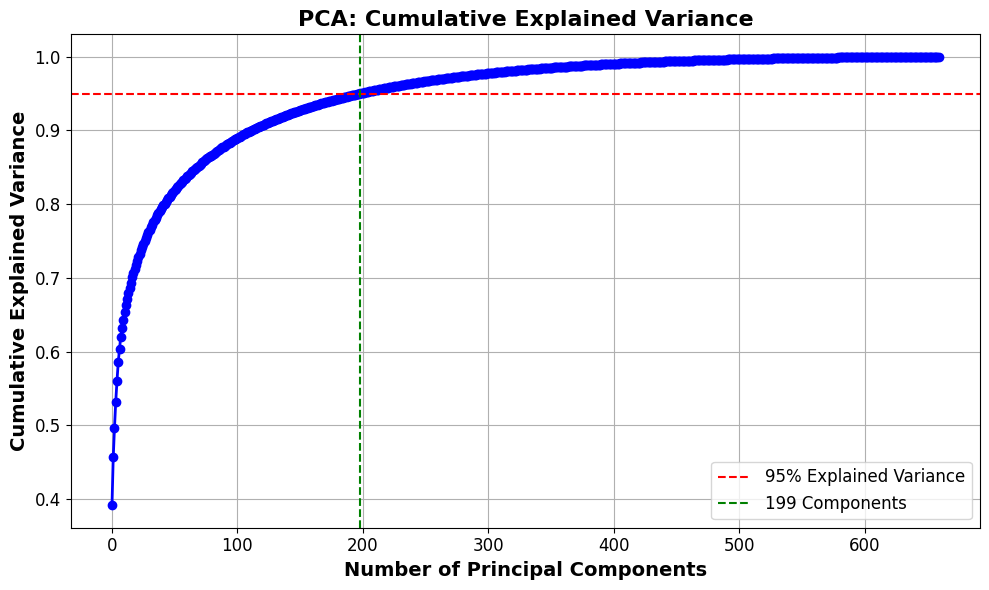

In [ ]:
# Path to data folder
directory = '../GATSol/dataset/'

# Load the DataFrame with embeddings
df = pd.read_pickle(directory + 'eSol_Test.pkl')

# Reshape embeddings
embeddings = np.stack(df['embedding'].values)
embeddings = np.squeeze(embeddings)
print("Shape of embeddings:", embeddings.shape)  # Should be (num_sequences, embedding_dim)

# Apply PCA without specifying n_components to analyze full explained variance
pca = PCA()
pca.fit(embeddings)

# Calculate cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # +1 because index 0 is the first component

print(f"Number of components needed for 95% variance: {d}")

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumsum, marker='o', linestyle='-', color='b', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=d - 1, color='g', linestyle='--', label=f'{d} Components')
plt.xlabel('Number of Principal Components', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.title('PCA: Cumulative Explained Variance', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
